In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
import os
from tqdm import tqdm
import time

In [2]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults

from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score as R2

In [3]:
arrest_data = pd.read_csv('edited_blotter_data.csv')
all_zip =  np.load('all_zip.npy')
zip_list = np.load('relevant_zip.npy')
arrest_data.drop(arrest_data.columns[0],axis = 1,inplace = True)

C:\Users\user\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
arrest_data.INCIDENTTIME = pd.to_datetime(arrest_data.INCIDENTTIME)
arrest_data['ZIP'] = all_zip
arrest_data = arrest_data[arrest_data.ZIP.isin(zip_list)]
arrest_data['year_month'] = pd.to_datetime(arrest_data['INCIDENTTIME']).apply(lambda x: '{year}-{month}'.format(year=x.year, month=x.month))
arrest_data_month_grouped = arrest_data.groupby(['ZIP','year_month']).agg({'PK':'count'})
arrest_data_month_grouped = arrest_data_month_grouped.add_suffix('_Count').reset_index()
arrest_data_month_grouped['month'] = (arrest_data_month_grouped.year_month).apply(
    lambda x : pd.to_datetime(x[:4]+"_"+x[5:],format = '%Y_%m'))

In [54]:
## Neighborhood 1: Allegheny center
def get_predictions(arrest_data_month_grouped,zip_,steps,p=12,d=1,q=1,visualize=False):
      
    grouped_neighborhood = arrest_data_month_grouped[arrest_data_month_grouped.ZIP == zip_].sort_values('month')
        
    model = None
    try:
        model = ARIMA(grouped_neighborhood.PK_Count.values,order=(p,d,q))
        fit = model.fit()
    except:
        q = 0
        model = ARIMA(grouped_neighborhood.PK_Count.values,order=(p,d,q))
        fit = model.fit()
        
    forecast = fit.forecast(steps)

    if visualize:
        plt.figure(figsize=(15,7))
        plt.plot(range(len(grouped_neighborhood)),grouped_neighborhood.PK_Count.values)
        plt.plot(range(len(grouped_neighborhood)-1,len(grouped_neighborhood)+len(forecast[0])-1),forecast[0],label='Predicted data')
#         plt.title('Prediction of Total Crimes for zipcode {}'.format(str(zip_)))
        plt.fill_between(range(len(grouped_neighborhood)-1,len(grouped_neighborhood)+len(forecast[0])-1),forecast[2][:,0],forecast[2][:,1],alpha=0.4)
        plt.axvline(x = len(grouped_neighborhood) - 1,color='r')
        plt.xlabel('Number of Months')
        plt.ylabel('Number of Crimes')
        plt.grid()
        plt.plot(range(len(train_data[train_data.ZIP == zip_]),len(train_data[train_data.ZIP == zip_])+steps),test_data.PK_Count[test_data.ZIP == zip_].values,label='Actual data')
        plt.legend()
        plt.savefig('images/predictions_'+str(zip_)+'.png',bbox_inches='tight')
        plt.show()
                
        # Lags of the original data
        plot_acf(grouped_neighborhood.PK_Count,lags=36)
#         plt.savefig('images/acf_original_'+str(zip_)+'.png',bbox_inches='tight')
        plot_pacf(grouped_neighborhood.PK_Count,lags=36)

        # Lags of the differenced data
        plot_acf(grouped_neighborhood.PK_Count.diff().dropna(),lags=36)
#         plt.savefig('images/acf_stationary_'+str(zip_)+'.png',bbox_inches='tight')
        plot_pacf(grouped_neighborhood.PK_Count.diff().dropna(),lags=36)
                
    return forecast

In [55]:
range(len(train_data),len(train_data)+12)

range(2700, 2712)

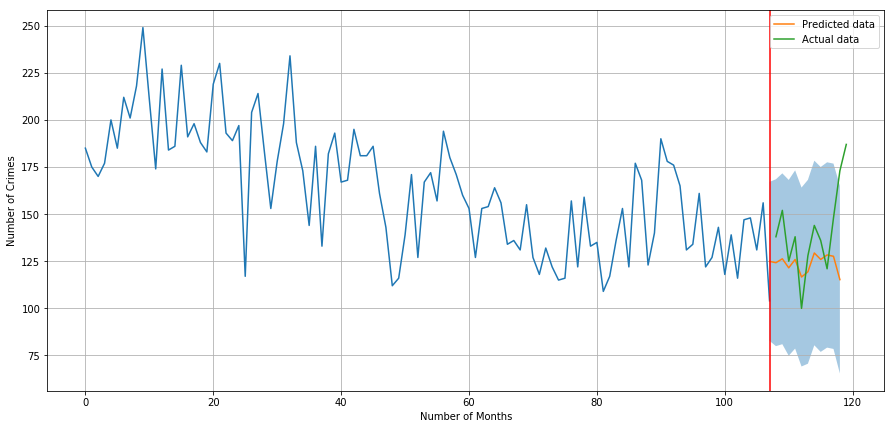

(array([124.9303569 , 124.2265079 , 126.30833714, 121.50170147,
        125.93507564, 116.62989323, 119.41093068, 129.38966556,
        125.94847938, 128.33673894, 127.63104744, 115.23476066]),
 array([21.51787794, 22.59309882, 23.1302258 , 23.7997385 , 24.12632006,
        24.22605206, 24.89099292, 24.99127698, 25.02885175, 25.08824587,
        25.08911409, 25.4132279 ]),
 array([[ 82.7560911 , 167.10462269],
        [ 79.94484792, 168.50816788],
        [ 80.97392761, 171.64274666],
        [ 74.85507116, 168.14833178],
        [ 78.64835724, 173.22179405],
        [ 69.1477037 , 164.11208277],
        [ 70.62548101, 168.19638035],
        [ 80.40766275, 178.37166837],
        [ 76.89283138, 175.00412739],
        [ 79.1646806 , 177.50879728],
        [ 78.45728741, 176.80480747],
        [ 65.42574923, 165.04377208]]))

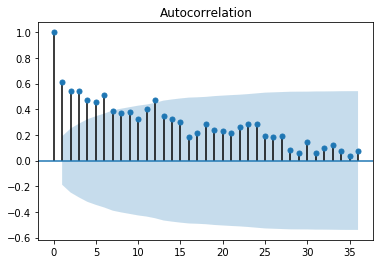

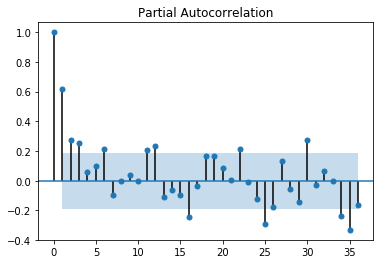

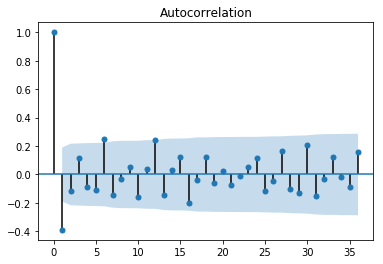

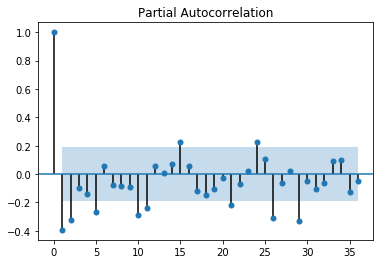

In [56]:
get_predictions(train_data,15213,steps=12,p=12,d=1,q=1,visualize=True)

384    365
385    453
386    484
387    398
388    337
389    467
390    384
391    461
392    412
393    479
394    596
395    467
Name: PK_Count, dtype: int64

In [ ]:
start = time.time()
forecast_track = []
zip_track = []
for zip_ in tqdm(arrest_data_month_grouped.ZIP.unique()):
    zip_track.append(zip_)
    try:
        forecast_track.append(float(get_predictions(arrest_data_month_grouped,zip_,1)[0]))        
    except:
        try:
            forecast_track.append(float(arrest_data_month_grouped,get_predictions(zip_,1,q=0)[0]))
        except:
            forecast_track.append(-1)
        
print ('Time taken:',time.time()-start,'s.')

 20%|████████████████▌                                                                  | 5/25 [00:38<02:23,  7.18s/it]

In [ ]:
forecast_df = pd.DataFrame()
forecast_df['Rank'] = range(1,len(zip_track)+1)
forecast_df['Zip_Code'] = zip_track
forecast_df['Incidents'] = list(map(int,forecast_track))

In [ ]:
forecast_df = forecast_df.sort_values('Incidents')[::-1]
forecast_df['Rank'] = range(1,len(zip_track)+1)
forecast_df.to_csv('forecast_df.csv')

In [28]:
train_data = arrest_data_month_grouped[arrest_data_month_grouped.month.dt.year < 2014]
validation_data = arrest_data_month_grouped[arrest_data_month_grouped.month.dt.year == 2014]
test_data = arrest_data_month_grouped[arrest_data_month_grouped.month.dt.year == 2015]

In [ ]:
from joblib import Parallel, delayed
import multiprocessing

def one_fold_cv(train_data, validation_data, test_data, zip_):
    best_mse = 1e6
    mse = []
    r2 = []
    for p in tqdm(range(11,19)):
        predictions = get_predictions(train_data,zip_,12,p=p)[0]
        actual = validation_data[validation_data.ZIP == zip_].PK_Count.values
        mse_value = MSE(predictions,actual)
        mse.append(mse_value)
        r2.append(R2(predictions,actual))
                
        if mse_value < best_mse:
            next_prediction = predictions[0]
            best_mse = mse_value
            best_p = p    
    
    test_prediction = get_predictions(pd.concat([train_data,validation_data]),zip_,12,p=best_p)
    
    return zip_,best_p,test_prediction,mse,r2            
            
def train_models(train_data,validation_data):
    predictions_df = pd.DataFrame()
    results = []
#     for zip_ in tqdm(zip_list):
#         zip_track.append(zip_)
#         ## This loop takes time
#         results.append(one_fold_cv(train_data,validation_data,zip_))
#         ##    
    results = Parallel(n_jobs=num_cores)(delayed(one_fold_cv)(train_data, validation_data, zip_) for zip_ in tqdm(zip_list))
    
        
#     predictions_df['Zip'] = zip_track
#     predictions_df['Incidents'] = predictions
        
    return results
        
# predictions2 = train_models(train_data,validation_data)

In [ ]:
# save = train_models(train_data,validation_data)

In [ ]:
num_cores = multiprocessing.cpu_count()
results = Parallel(n_jobs=num_cores)(delayed(processInput)(i) for i in inputs)

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(([save[j][1] for j in range(25)])[24])

In [ ]:
tp = get_predictions(pd.concat([train_data,validation_data]),15203,12,p=12)
MSE(test_data[test_data.ZIP == 15203].PK_Count.values,tp[0])

In [ ]:
test_data[validation_data.ZIP == 15203]]

In [6]:
# ADF test on raw data (without transformation)

df_test = adfuller(arrest_data_month_grouped['PK_Count'], autolag='AIC')
result = pd.Series(df_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in df_test[4].items():
    result['Critical Value (%s)'%key] = value
print (result)

Test Statistic                   -4.988532
p-value                           0.000023
#Lags Used                       29.000000
Number of Observations Used    3270.000000
Critical Value (1%)              -3.432351
Critical Value (5%)              -2.862424
Critical Value (10%)             -2.567241
dtype: float64


### 1. Difference between data and moving average

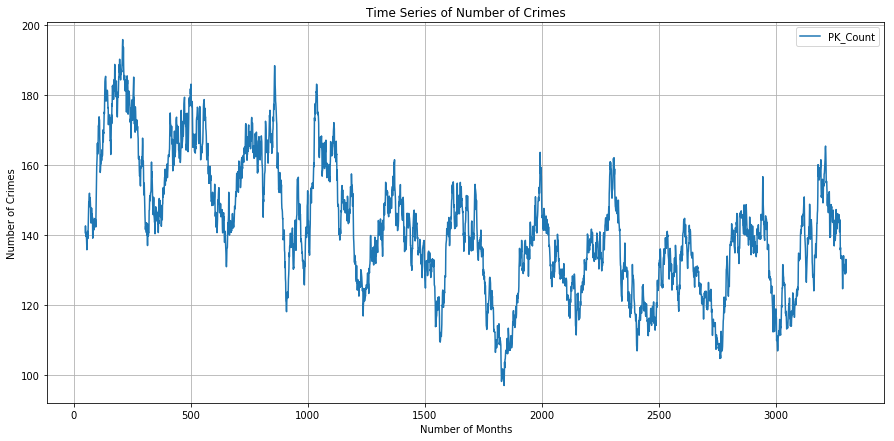

(141.75409412488472, 18.32479242831079)

In [8]:
# Calculate and plot the rolling mean
grouped_neighborhood = arrest_data_month_grouped.sort_values('month')
plt.figure(figsize=(15,7))
rolling_mean = pd.Series.rolling(grouped_neighborhood['PK_Count'],window=50,center=False).mean()
#rate_data.plot()
plt.plot(range(1,len(rolling_mean)+1),rolling_mean)
plt.legend(loc='best')
plt.grid()
plt.title('Time Series of Number of Crimes')
plt.xlabel('Number of Months')
plt.ylabel('Number of Crimes')
plt.savefig('time_series.png',bbox_inches='tight')
plt.show()
rolling_mean.mean(),rolling_mean.std()

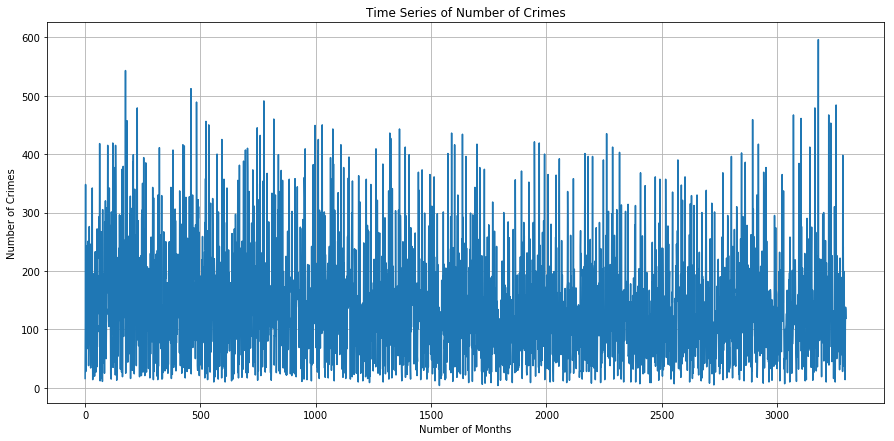

141.6469696969697

91.2841957911767

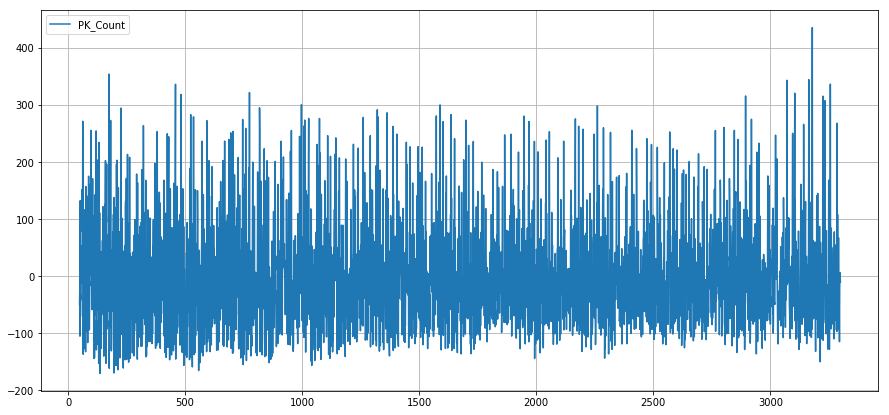

In [9]:
# Subtract rolling mean from the data and plot
plt.figure(figsize=(15,7))
plt.plot(range(len(grouped_neighborhood['PK_Count'])),grouped_neighborhood['PK_Count'])
plt.xlabel('Number of Months')
plt.ylabel('Number of Crimes')
plt.title('Time Series of Number of Crimes')
plt.grid()
plt.savefig('images/time_series.png',bbox_inches='tight')
plt.show()
display(grouped_neighborhood['PK_Count'].mean(),grouped_neighborhood['PK_Count'].std())

rolling_mean_diff=(grouped_neighborhood['PK_Count']-rolling_mean)
plt.figure(figsize=(15,7))
plt.plot(range(len(rolling_mean_diff)),rolling_mean_diff)
plt.legend(loc='best')
plt.grid()
plt.show()
rolling_mean_diff.dropna(inplace=True)

In [10]:
df_test = adfuller(rolling_mean_diff, autolag='AIC')
result = pd.Series(df_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in df_test[4].items():
    result['Critical Value (%s)'%key] = value
print (result)

Test Statistic                  -20.146878
p-value                           0.000000
#Lags Used                       10.000000
Number of Observations Used    3240.000000
Critical Value (1%)              -3.432370
Critical Value (5%)              -2.862432
Critical Value (10%)             -2.567245
dtype: float64


### 2. Moving average of log(data)

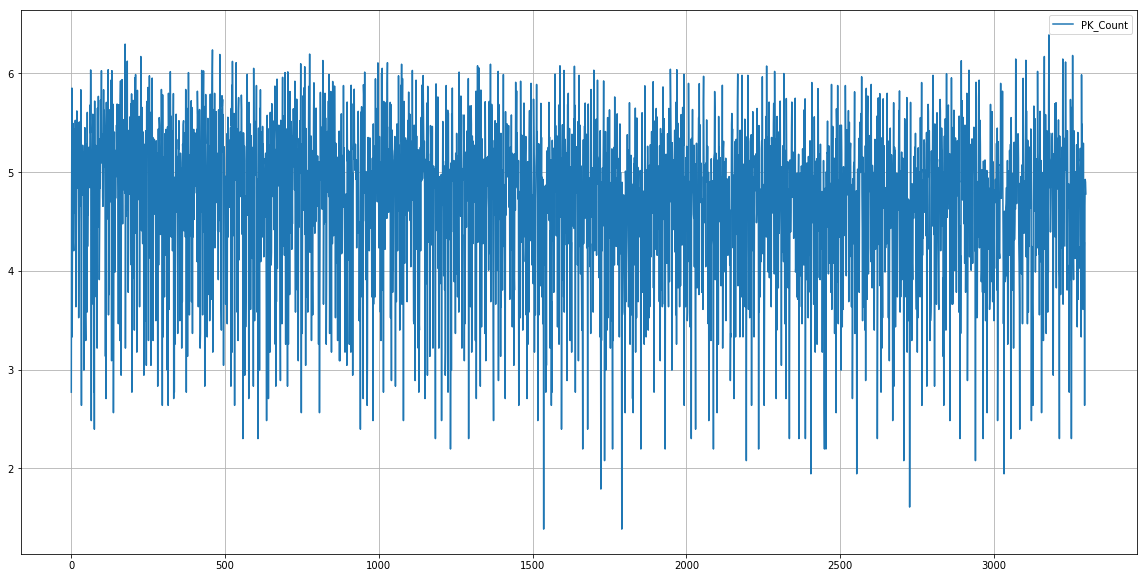

In [11]:
# Calculate and plot logarithm of the data
plt.figure(figsize=(20,10))
rate_data_log=np.log(grouped_neighborhood['PK_Count'])
plt.plot(range(len(rate_data_log)),rate_data_log)
plt.legend(loc='best')
plt.grid()
plt.show()

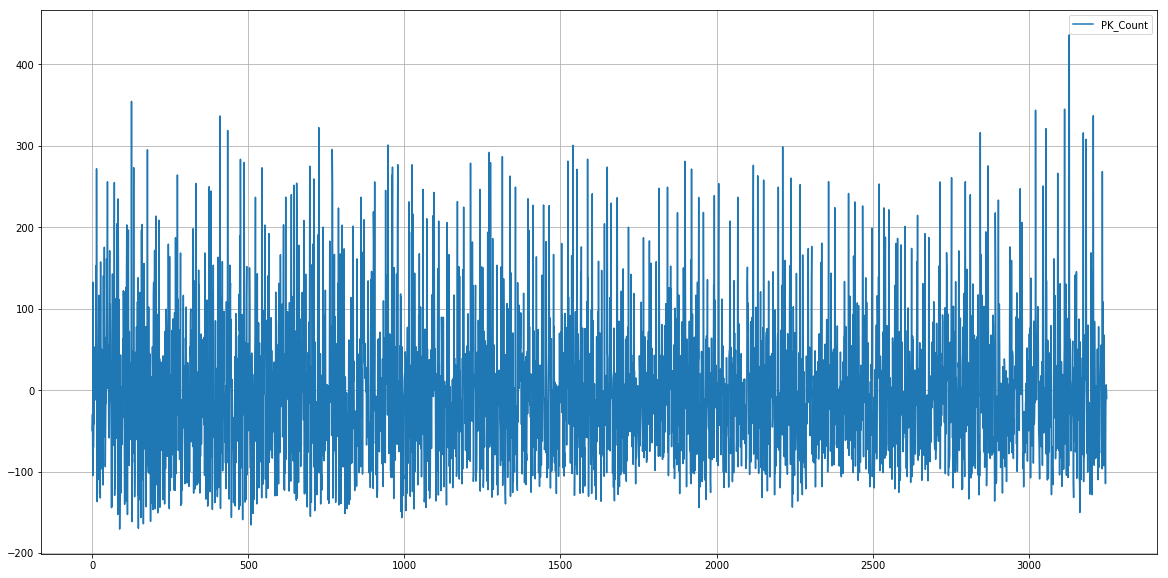

In [12]:
# Calculate and plot differnece between rolling mean of logarithm and the logarithm
plt.figure(figsize=(20,10))
log_rolling_mean=pd.Series.rolling(rate_data_log,window=10,center=False).mean()
log_rolmean_diff=rate_data_log-log_rolling_mean
plt.plot(range(len(rolling_mean_diff)),rolling_mean_diff)
plt.legend(loc='best')
plt.grid()
plt.show()
log_rolmean_diff.dropna(inplace=True)

In [13]:
# Perform ADF on the transformation
df_test_log = adfuller(log_rolmean_diff, autolag='AIC')
result_log = pd.Series(df_test_log[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in df_test_log[4].items():
    result_log['Critical Value (%s)'%key] = value
print (result_log)

Test Statistic                -1.850860e+01
p-value                        2.115985e-30
#Lags Used                     2.900000e+01
Number of Observations Used    3.261000e+03
Critical Value (1%)           -3.432357e+00
Critical Value (5%)           -2.862427e+00
Critical Value (10%)          -2.567242e+00
dtype: float64


### 3. Exponentially Weighted Moving Average of Log

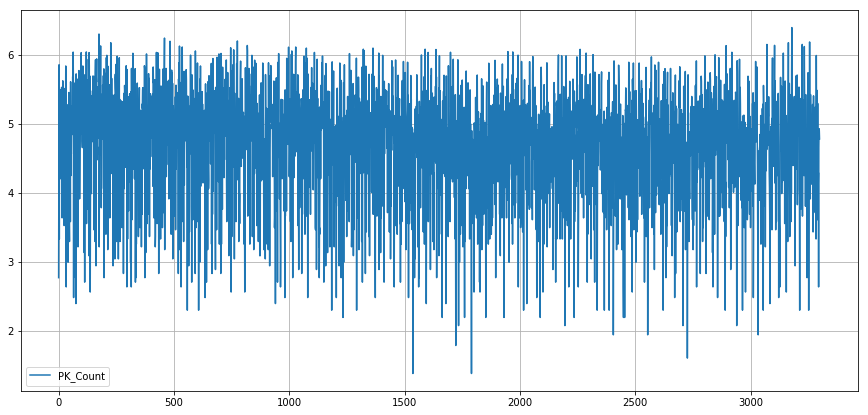

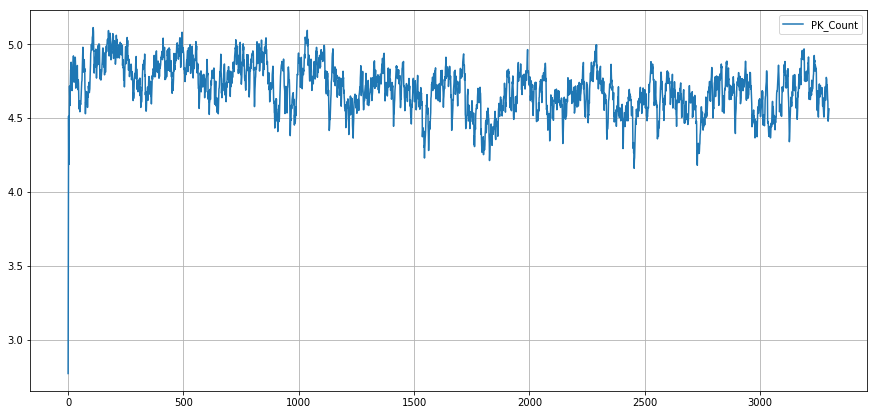

In [14]:
plt.figure(figsize=(15,7))
ewma_data=pd.Series.ewm(rate_data_log,halflife=10,min_periods=0,adjust=True,ignore_na=False).mean()
plt.plot(range(len(rate_data_log)),rate_data_log)
plt.legend(loc='best')
plt.grid()
plt.show()

# Calculate EWMA and plot
plt.figure(figsize=(15,7))
plt.plot(range(len(ewma_data)),ewma_data)
plt.legend(loc='best')
plt.grid()
plt.show()

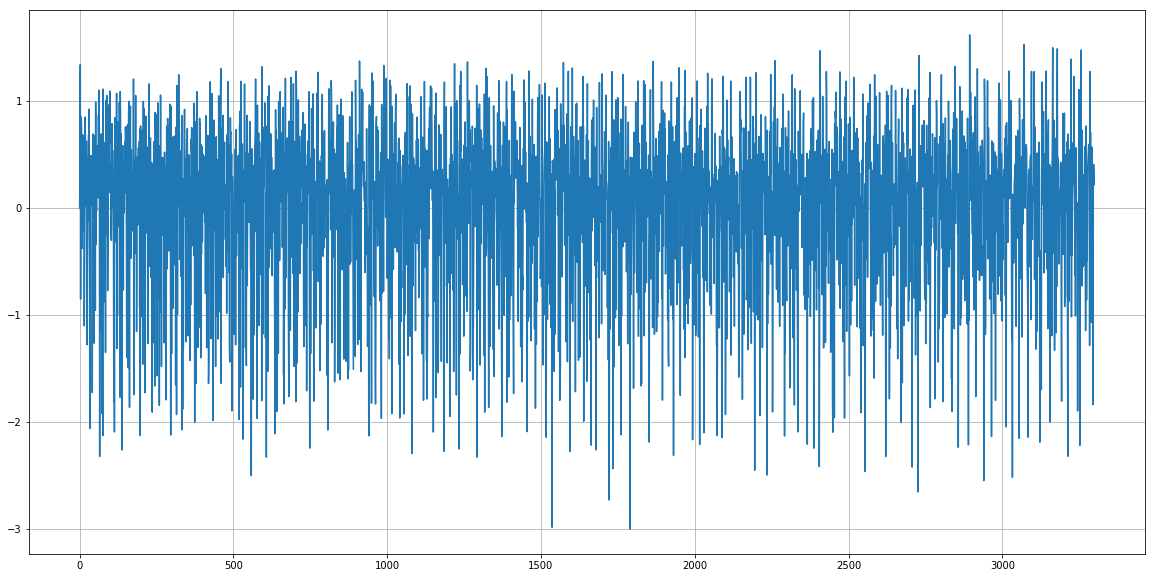

In [15]:
# Calculate and plot difference
plt.figure(figsize=(20,10))
ewma_diff=rate_data_log-ewma_data
plt.plot(range(len(ewma_diff)),ewma_diff)
plt.grid()
plt.show()

In [16]:
# Perform ADF test

df_test_ewma = adfuller(ewma_diff, autolag='AIC')
result_ewma = pd.Series(df_test_ewma[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in df_test_ewma[4].items():
    result_ewma['Critical Value (%s)'%key] = value
print (result_ewma)

Test Statistic                -1.528313e+01
p-value                        4.548969e-28
#Lags Used                     2.800000e+01
Number of Observations Used    3.271000e+03
Critical Value (1%)           -3.432351e+00
Critical Value (5%)           -2.862424e+00
Critical Value (10%)          -2.567241e+00
dtype: float64


### 4. First order differencing

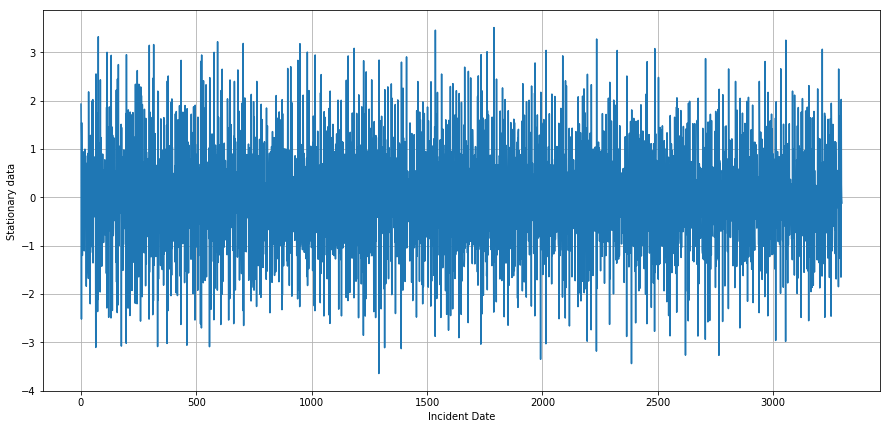

(0.0006082251503097144, 1.1290246250746034)

In [17]:
# Calculate and plot the first order differnece
plt.figure(figsize=(15,7))
rate_log_diff = rate_data_log - rate_data_log.shift()
rate_log_diff.dropna(inplace=True)
plt.plot(range(len(rate_log_diff)),rate_log_diff)
# plt.legend('First Order Differenced Log Data')
# plt.legend(loc='best')
plt.xlabel('Incident Date')
plt.ylabel('Stationary data')
plt.grid()
plt.savefig('images/stationary_series.png',bbox_inches='tight')
plt.show()
rate_log_diff.mean(),rate_log_diff.std()

In [18]:
# Perform ADF test

df_test_logdiff = adfuller(rate_log_diff, autolag='AIC')
result_logdiff = pd.Series(df_test_logdiff[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in df_test_logdiff[4].items():
    result_logdiff['Critical Value (%s)'%key] = value
print (result_logdiff)

Test Statistic                  -19.514172
p-value                           0.000000
#Lags Used                       28.000000
Number of Observations Used    3270.000000
Critical Value (1%)              -3.432351
Critical Value (5%)              -2.862424
Critical Value (10%)             -2.567241
dtype: float64


In [19]:
compare=pd.DataFrame({'Test Statistic':[result.iloc[0],result_log.iloc[0],result_ewma.iloc[0],result_logdiff.iloc[0]],
                      'p-value':[result.iloc[1],result_log.iloc[1],result_ewma.iloc[1],result_logdiff.iloc[1]]})
Methods=['Data Rolling mean','Log Data Rolling Mean','Log EWMA','First Order Differencing']
compare['Methods']=Methods
compare=compare.set_index('Methods')
compare

,Test Statistic,p-value
Methods,,
Data Rolling mean,-20.146878,0.000000e+00
Log Data Rolling Mean,-18.508599,2.115985e-30
Log EWMA,-15.283130,4.548969e-28
First Order Differencing,-19.514172,0.000000e+00


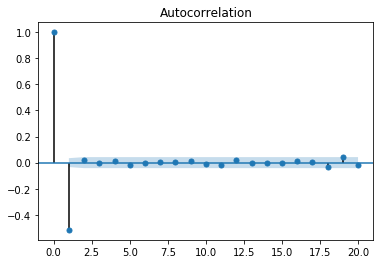

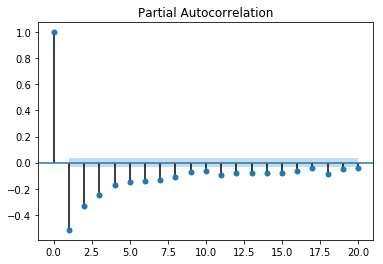

In [20]:
plot_acf(rate_log_diff,lags=20)
plt.savefig('acf.png',bbox_inches='tight')
plt.show()

plot_pacf(rate_log_diff,lags=20)
plt.savefig('pacf.png',bbox_inches='tight')
plt.show()

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: 'pandas.tools.plotting.table' is deprecated, import 'pandas.plotting.table' instead.
  import sys


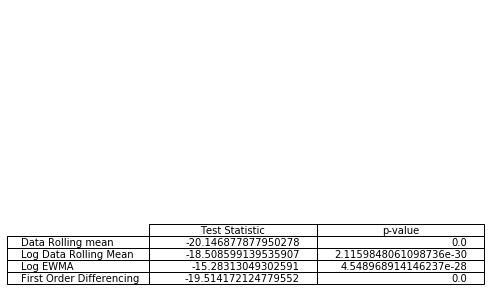

In [23]:
from pandas.tools.plotting import table

ax = plt.subplot(111, frame_on=False) # no visible frame
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis

table(ax, compare)
plt.savefig('stat_compare.png',bbox_inches='tight')
plt.show()